# Text Mining Hand-In Assignment 2

Student: Elin Benja Dijkstra (s2696096)

## Import needed packages

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
from itertools import chain

import nltk
import sklearn
import scipy.stats
import os
import numpy as np
import re 
import pandas as pd

from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_predict

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

from collections import Counter, OrderedDict
from itertools import groupby


## Load and process the data

The bio files are basically text files. I read in one document at a time, line by line and turn each line to a tuple. If it occurs that the tuple is not of length 3, do not add it to our data. 

We end up with a list of lists of length 22.

In [3]:
def load_process_data():
    path = os.getcwd() + "/bio"
    file_array = []
    missingvalues_array = []
    for filename in os.listdir(path):
        file  = open(path + "/" + filename, 'r', encoding='utf-8')
        triple_array = []
        missingvalues = 0
        for line in file.readlines():
            line = tuple(line.split())
            if (len(line) == 3): # only add tri tuples
                triple_array.append(line) # add to the list of a specific file
            else: missingvalues +=1
        missingvalues_array.append(missingvalues)
        file_array.append(triple_array) # add to the list of files
    
    print("Missing values\n", missingvalues_array)
    return file_array

## Features

Next, define some features. In this example we use word identity, word suffix, word shape and word POS tag; also, some information from nearby words is used. 

This makes a simple baseline, but you certainly can add and remove some features to get (much?) better results - experiment with it.

sklearn-crfsuite (and python-crfsuite) supports several feature formats; here we use feature dicts.

In [4]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],        
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True
        
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True
                
    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

Extract features from the data:

In [5]:
def extract_features(data):
    X = [sent2features(s) for s in data]
    y = [sent2labels(s) for s in data]
    
    return X, y

## Data Exploration

In [6]:
def data_exploration(data):
#     words = []
#     for document in data:
#         words.append([word for (word, postag, label) in document])
        
#     words_transformed = [" ".join(x) for x in words]
#     vectorizer = TfidfVectorizer(stop_words = 'english')
#     tfidf_vectorizer_vectors = vectorizer.fit_transform(words_transformed)
#     # get the first vector out (for the first document)
#     first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[0]

#     # place tf-idf values in a pandas data frame
#     df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=vectorizer.get_feature_names(), columns=["tfidf"])
#     sorted_df = df.sort_values(by=["tfidf"],ascending=False).head(15) 
#     display(sorted_df)
#     plt.barh(y = sorted_df.index, width = sorted_df.tfidf)
#     plt.title("Top 15 TF-IDF scores for document 1")
    
    postags = []
    for document in data:
        for line in document:
            postags.append(line[1])
    
    counter=Counter(postags)
    counter = OrderedDict(counter.most_common(15))
    keys = [str(e) for e in list(counter.keys())]
    plt.figure(figsize = (15,8))
    plt.barh(y = keys, width = list(counter.values()))
    # fontsize of the x and y labels
    plt.rc('ytick', labelsize=20) 
    plt.title("Frequency of POStags")
    
        

## Training

To see all possible CRF parameters check its docstring. Here we are useing L-BFGS training algorithm (it is default) with Elastic Net (L1 + L2) regularization.

In [7]:
def train(X_train, y_train):
    crf = sklearn_crfsuite.CRF(
        algorithm='lbfgs', 
        c1=0.1, 
        c2=0.1, 
        max_iterations=100, 
        all_possible_transitions=True
    )
    crf.fit(X_train, y_train)
    return crf

## Evaluation

There is much more O entities in data set, but we're more interested in other entities. To account for this we'll use averaged F1 score computed for all labels except for O. ``sklearn-crfsuite.metrics`` package provides some useful metrics for sequence classification task, including this one.

In [8]:
def remove_o(crf):
    labels = list(crf.classes_)
    labels.remove('O')
    return labels

Inspect per-class results in more detail:

In [9]:
def evaluate(crf, X_test, y_test):
    labels = remove_o(crf)
    y_pred = crf.predict(X_test)

    metrics.flat_f1_score(y_test, y_pred, 
                          average='weighted', labels=labels)

    # group B and I results
    sorted_labels = sorted(
        labels, 
        key=lambda name: (name[1:], name[0])
    )
    print(metrics.flat_classification_report(
        y_test, y_pred, labels=sorted_labels, digits=3
    ))
    return y_pred, labels

## Hyperparameter Search

In [10]:
def hyperparameter_search(X_train, y_train, labels):
    %%time
    # define fixed parameters and parameters to search
    crf = sklearn_crfsuite.CRF(
        algorithm='lbfgs', 
        max_iterations=50, 
        all_possible_transitions=True
    )
    params_space = {
        'c1': scipy.stats.expon(scale=0.5),
        'c2': scipy.stats.expon(scale=0.05),
    }

    # use the same metric for evaluation
    f1_scorer = make_scorer(metrics.flat_f1_score, 
                            average='weighted', labels=labels)

    group_kfold = GroupKFold(n_splits=5)
    # search
    rs = RandomizedSearchCV(crf, params_space, 
                            cv=group_kfold, 
                            verbose=3, 
                            n_jobs=-1, 
                            n_iter=20, 
                            scoring=f1_scorer)
    rs.fit(X_train, y_train, groups = list(range(len(X_train))))
    
    crf = rs.best_estimator_
    print('best params:', rs.best_params_)
    print('best CV score:', rs.best_score_)
    print('model size: {:0.2f}M'.format(crf.size_ / 1000000))
    
    return crf

In [11]:
def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

In [12]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))    

## Start the run

Missing values
 [1, 17, 0, 2, 5, 8, 1, 1, 1, 1, 8, 5, 0, 1, 17, 28, 3, 3, 1, 2, 13, 5]


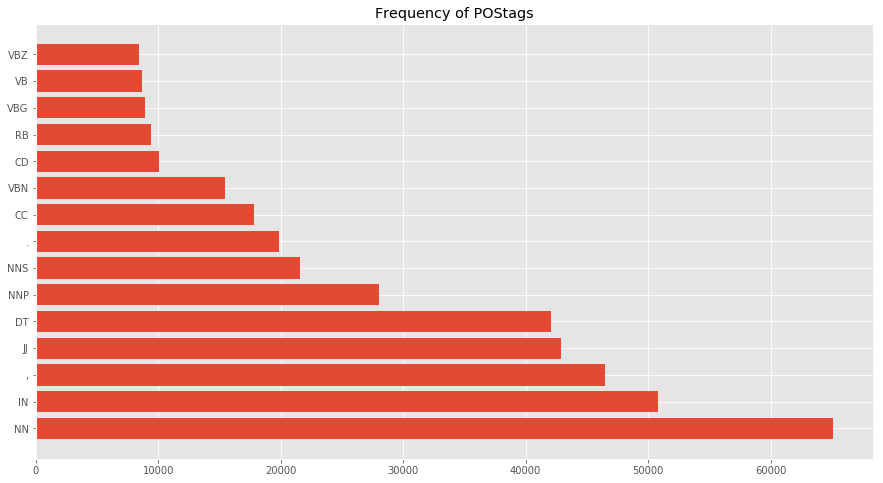

In [13]:
data = load_process_data()
X, y = extract_features(data)
data_exploration(data)


In [14]:
def main():
    group_kfold = GroupKFold(n_splits=5)
    for train_index, test_index in group_kfold.split(data, groups = list(range(22))):
        X_train = np.array(X)[train_index]
        y_train = np.array(y)[train_index]
        init_fit = train(X_train, y_train)
        labels = remove_o(init_fit)
        best_crf = hyperparameter_search(X_train, y_train, labels)
        evaluate(best_crf, np.array(X)[test_index], np.array(y)[test_index])

In [15]:
%%time
main()

Wall time: 0 ns
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.6min
C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.5min finished
C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best params: {'c1': 0.09994205843183236, 'c2': 0.0031354463909522567}
best CV score: 0.7968316974497829
model size: 0.76M
              precision    recall  f1-score   support

           B      0.868     0.737     0.797       659
           I      0.890     0.896     0.893      5396

   micro avg      0.888     0.879     0.883      6055
   macro avg      0.879     0.817     0.845      6055
weighted avg      0.888     0.879     0.883      6055

Wall time: 0 ns
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.1min
C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.2min finished
C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best params: {'c1': 0.4625004326290921, 'c2': 0.01651021565474791}
best CV score: 0.8511101903207982
model size: 0.40M
              precision    recall  f1-score   support

           B      0.827     0.651     0.729       645
           I      0.832     0.760     0.795      5237

   micro avg      0.832     0.748     0.788      5882
   macro avg      0.829     0.706     0.762      5882
weighted avg      0.832     0.748     0.787      5882

Wall time: 0 ns
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.8min
C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.1min finished
C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best params: {'c1': 0.20013893728929172, 'c2': 0.10918987093464938}
best CV score: 0.8256680193340975
model size: 0.86M
              precision    recall  f1-score   support

           B      0.891     0.779     0.832       526
           I      0.947     0.869     0.906      4318

   micro avg      0.941     0.859     0.898      4844
   macro avg      0.919     0.824     0.869      4844
weighted avg      0.941     0.859     0.898      4844

Wall time: 0 ns
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.3min
C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 13.3min finished
C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best params: {'c1': 0.11178404132259695, 'c2': 0.021719064405032122}
best CV score: 0.8390795241780442
model size: 0.96M
              precision    recall  f1-score   support

           B      0.904     0.689     0.782       151
           I      0.966     0.825     0.890      1216

   micro avg      0.960     0.810     0.879      1367
   macro avg      0.935     0.757     0.836      1367
weighted avg      0.959     0.810     0.878      1367

Wall time: 0 ns
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.2min
C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.9min finished
C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best params: {'c1': 0.2609182280735074, 'c2': 0.026953733586898607}
best CV score: 0.8435620433828053
model size: 0.89M
              precision    recall  f1-score   support

           B      0.714     0.575     0.637       113
           I      0.826     0.810     0.818       779

   micro avg      0.814     0.780     0.797       892
   macro avg      0.770     0.693     0.728       892
weighted avg      0.812     0.780     0.795       892

Wall time: 59min 32s


## Add word length feature

In [16]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],    
        'word.length': len(word)
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
            'word.length': len(word)
        })
    else:
        features['BOS'] = True
        
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],    
            'word.length': len(word)
        })
    else:
        features['EOS'] = True
                
    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [17]:
%%time
main()

Wall time: 0 ns
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.7min
C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.7min finished
C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best params: {'c1': 0.058685829954342204, 'c2': 0.033091161880681445}
best CV score: 0.7961994476827181
model size: 1.01M
              precision    recall  f1-score   support

           B      0.867     0.751     0.805       659
           I      0.898     0.905     0.902      5396

   micro avg      0.895     0.888     0.892      6055
   macro avg      0.883     0.828     0.853      6055
weighted avg      0.895     0.888     0.891      6055

Wall time: 0 ns
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.2min finished
C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best params: {'c1': 0.5554646362715262, 'c2': 0.007458040699262834}
best CV score: 0.8490716061239597
model size: 0.35M
              precision    recall  f1-score   support

           B      0.820     0.650     0.725       645
           I      0.834     0.765     0.798      5237

   micro avg      0.833     0.752     0.791      5882
   macro avg      0.827     0.707     0.762      5882
weighted avg      0.833     0.752     0.790      5882

Wall time: 0 ns
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.8min
C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.1min finished
C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best params: {'c1': 0.1394539618476601, 'c2': 0.10611580645486243}
best CV score: 0.8257067270205494
model size: 0.99M
              precision    recall  f1-score   support

           B      0.888     0.768     0.824       526
           I      0.946     0.852     0.897      4318

   micro avg      0.940     0.843     0.889      4844
   macro avg      0.917     0.810     0.860      4844
weighted avg      0.939     0.843     0.889      4844

Wall time: 0 ns
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.3min
C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 13.3min finished
C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best params: {'c1': 0.2434861513225541, 'c2': 0.049802382698524536}
best CV score: 0.8268774886538308
model size: 0.78M
              precision    recall  f1-score   support

           B      0.908     0.722     0.804       151
           I      0.957     0.840     0.894      1216

   micro avg      0.952     0.827     0.885      1367
   macro avg      0.933     0.781     0.849      1367
weighted avg      0.952     0.827     0.884      1367

Wall time: 0 ns
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.2min
C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.9min finished
C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best params: {'c1': 0.16367881409705692, 'c2': 0.014749670934174628}
best CV score: 0.8452395547461986
model size: 1.07M
              precision    recall  f1-score   support

           B      0.685     0.540     0.604       113
           I      0.825     0.780     0.802       779

   micro avg      0.810     0.750     0.779       892
   macro avg      0.755     0.660     0.703       892
weighted avg      0.807     0.750     0.777       892

Wall time: 59min 35s


## Add symbol feature

In [18]:
def check_symbol(word):
    string_check= re.compile('[@_!#$%^&*()<>?/\|}{~:]') 
    if string_check.search(word) == None:
        return False
    else :
        return True

In [19]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2], 
        'word.containssympol()': check_symbol(word)
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
            'word.containssympol()': check_symbol(word)
        })
    else:
        features['BOS'] = True
        
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],   
            'word.containssympol()': check_symbol(word) 
        })
    else:
        features['EOS'] = True
                
    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [20]:
%%time
main()

Wall time: 0 ns
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.6min
C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.7min finished
C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best params: {'c1': 0.09847835964730725, 'c2': 0.046092110683638894}
best CV score: 0.7987941201501875
model size: 0.84M
              precision    recall  f1-score   support

           B      0.868     0.756     0.808       659
           I      0.895     0.893     0.894      5396

   micro avg      0.892     0.878     0.885      6055
   macro avg      0.881     0.824     0.851      6055
weighted avg      0.892     0.878     0.884      6055

Wall time: 0 ns
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.1min
C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.4min finished
C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best params: {'c1': 0.07230473105888094, 'c2': 0.006372493871530139}
best CV score: 0.8473722333337108
model size: 0.74M
              precision    recall  f1-score   support

           B      0.805     0.678     0.736       645
           I      0.819     0.769     0.793      5237

   micro avg      0.818     0.759     0.787      5882
   macro avg      0.812     0.723     0.764      5882
weighted avg      0.818     0.759     0.787      5882

Wall time: 0 ns
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.8min
C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.3min finished
C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best params: {'c1': 0.13443209007021212, 'c2': 0.12271300755937305}
best CV score: 0.8226926335335174
model size: 1.03M
              precision    recall  f1-score   support

           B      0.885     0.760     0.818       526
           I      0.946     0.852     0.897      4318

   micro avg      0.940     0.842     0.888      4844
   macro avg      0.915     0.806     0.857      4844
weighted avg      0.939     0.842     0.888      4844

Wall time: 0 ns
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.4min
C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 13.3min finished
C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best params: {'c1': 0.06608143283498547, 'c2': 0.0013969005865775385}
best CV score: 0.8313923462872839
model size: 1.02M
              precision    recall  f1-score   support

           B      0.889     0.689     0.776       151
           I      0.953     0.857     0.903      1216

   micro avg      0.947     0.838     0.889      1367
   macro avg      0.921     0.773     0.839      1367
weighted avg      0.946     0.838     0.889      1367

Wall time: 0 ns
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.2min
C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 13.0min finished
C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best params: {'c1': 0.13160091402169588, 'c2': 0.0022840643480738993}
best CV score: 0.8444922976623161
model size: 1.33M
              precision    recall  f1-score   support

           B      0.656     0.522     0.581       113
           I      0.829     0.770     0.798       779

   micro avg      0.810     0.739     0.773       892
   macro avg      0.742     0.646     0.690       892
weighted avg      0.807     0.739     0.771       892

Wall time: 1h 13s


## Larger context

In [21]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],    
    }
    if i > 0:
        word1 = sent[i-2][0]
        postag1 = sent[i-2][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
            'word.length': len(word)
        })
    else:
        features['BOS'] = True
        
    if i > 1:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
            'word.length': len(word)
        })
        
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],    
            'word.length': len(word)
        })
    else:
        features['EOS'] = True
        
    if i < len(sent)-2:
        word1 = sent[i+2][0]
        postag1 = sent[i+2][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],    
            'word.length': len(word)
        })
                
    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [22]:
%%time
main()

Wall time: 0 ns
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.7min
C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.7min finished
C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best params: {'c1': 0.08969621003142562, 'c2': 0.02617614820775061}
best CV score: 0.7968614175738585
model size: 0.86M
              precision    recall  f1-score   support

           B      0.863     0.747     0.801       659
           I      0.896     0.891     0.894      5396

   micro avg      0.893     0.875     0.884      6055
   macro avg      0.880     0.819     0.847      6055
weighted avg      0.893     0.875     0.884      6055

Wall time: 0 ns
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.1min
C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.3min finished
C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best params: {'c1': 0.09166776445766867, 'c2': 0.0337860262022205}
best CV score: 0.8410120904398518
model size: 0.75M
              precision    recall  f1-score   support

           B      0.800     0.678     0.734       645
           I      0.809     0.773     0.791      5237

   micro avg      0.808     0.762     0.785      5882
   macro avg      0.805     0.725     0.762      5882
weighted avg      0.808     0.762     0.784      5882

Wall time: 0 ns
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.8min
C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.1min finished
C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best params: {'c1': 0.08454514519418253, 'c2': 0.036026515932323304}
best CV score: 0.8255677168856652
model size: 1.04M
              precision    recall  f1-score   support

           B      0.892     0.768     0.825       526
           I      0.947     0.859     0.901      4318

   micro avg      0.941     0.849     0.893      4844
   macro avg      0.919     0.814     0.863      4844
weighted avg      0.941     0.849     0.893      4844

Wall time: 0 ns
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.3min
C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 13.3min finished
C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best params: {'c1': 0.17869140625447832, 'c2': 0.055418872246143794}
best CV score: 0.8361235985366412
model size: 0.96M
              precision    recall  f1-score   support

           B      0.893     0.715     0.794       151
           I      0.955     0.840     0.894      1216

   micro avg      0.949     0.827     0.884      1367
   macro avg      0.924     0.778     0.844      1367
weighted avg      0.948     0.827     0.883      1367

Wall time: 0 ns
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.2min
C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.9min finished
C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best params: {'c1': 0.23481528589465045, 'c2': 0.016768022530698593}
best CV score: 0.8446651314039717
model size: 0.92M
              precision    recall  f1-score   support

           B      0.736     0.566     0.640       113
           I      0.839     0.816     0.828       779

   micro avg      0.828     0.785     0.806       892
   macro avg      0.787     0.691     0.734       892
weighted avg      0.826     0.785     0.804       892

Wall time: 59min 47s


In [ ]:
# def main():
#     data = load_process_data()
#     crflist = []
#     group_kfold = GroupKFold(n_splits=5)
#     for train_index, test_index in group_kfold.split(data, groups = list(range(22))):
#         print("TRAIN DOCS:", train_index, "TEST DOCS:", test_index)
#         X_train, X_test = np.array(data)[train_index], np.array(data)[test_index]
#         print("Size training set:", len(X_train), "Size test set:", len(X_test))
        
#         X_train, y_train, X_test, y_test = extract_features(X_train, X_test)
#         crf_fit = train(X_train, y_train)
#         y_pred, labels = evaluate(crf_fit, X_test, y_test)
#         best_crf = hyperparameter_search(X_train, y_train, labels)
#         crflist.append(best_crf)
#         evaluate(best_crf, X_test, y_test)
    
#         print("Likeliness of transitions:")
#         print_transitions(Counter(crf_fit.transition_features_).most_common(20))
#         print("Top positive:")
#         print_state_features(Counter(crf_fit.state_features_).most_common(20))
    

In [ ]:
# def main():
#     data = load_process_data()
#     train_index = list(range(18))
#     test_index = [18, 19, 20, 21]
#     X_train, X_test = np.array(data)[train_index], np.array(data)[test_index]
#     print("Size training set:", len(X_train), "Size test set:", len(X_test))
#     X_train, y_train, X_test, y_test = extract_features(X_train, X_test)
# #     data_exploration(data, X_train, y_train, X_test, y_test)
#     crf_fit = train(X_train, y_train)
#     y_pred, labels = evaluate(crf_fit, X_test, y_test)
#     best_crf = hyperparameter_search(X_train, y_train, labels)
#     evaluate(best_crf, X_test, y_test)

# #     print("Likeliness of transitions:")
# #     print_transitions(Counter(best_crf.transition_features_).most_common(20))
# #     print("Top positive:")
# #     print_state_features(Counter(best_crf.state_features_).most_common(20))
    
# #     return best_crf